In [1]:
# Noisy_Quartic
# In the paper Ngen=3000 NPAR=100 RUNS=50 dim=30
# JADE: Adaptive Differential Evolution with Optional External Archive


In [2]:
#  cd C:/Users/TREX/Desktop/Lockdown Paper Raiana/notebooks


In [3]:
import Go2Ann
import de_soma_Insight
import de_bounds_matriz
import Function
import Go2MinMax
from AvaliaX import AvaliaX
from GeraIndices import GeraIndices

############################### DADOS DE ENTRADA 
RUNS=50 #NÚMERO DE RODADAS
Fc=0.1 # fator de correcao parametros da ANN
its=1 #10 # quantas vezes vai usar o NPAR antes de alterar de novo
ITE=3000 #10 # PONTOS quantas vezes vai alteral NPAR 
NPAR=100

mut=0.5
crossp=0.5
Fi=mut;CRi=crossp;# para impressão

############################### Função
dim=30
NPAR=int(NPAR/2) # half of particles use mutated F and CR and other not
#fchoice='Rastrigin' #fchoice='Michalewicz' #fchoice='Schwefel'
fchoice='Noisy_Quartic'
Fun=Function.Noisy_Quartic

MIN,MAX=Go2MinMax.Intervalo(dim,fchoice)
PAR=len(MAX) #NUM DE PARAMETROS A SER OTIMIZADOS


In [4]:
import time
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from scipy import optimize
import pandas as pd
from sklearn.metrics import confusion_matrix

In [5]:
ANN_F=pd.read_csv('ANN_INSIGHT_Valor_F.csv')

In [6]:
ANN_CR=pd.read_csv('ANN_INSIGHT_CR.csv')

In [7]:
syn0_F,syn1_F,X_max_F,X_min_F=Go2Ann.GetMatriz(ANN_F)

In [8]:
syn0_CR,syn1_CR,X_max_CR,X_min_CR=Go2Ann.GetMatriz(ANN_CR)

In [9]:
ANN_CR=pd.read_csv('ANN_INSIGHT_CR.csv')

In [10]:
fields = ['DI RELATIVO','FRAC Its','Fo','CRo']

In [11]:
##################################### 

#TOTAL=7*dim*its*ITE
TOTAL=10*dim*its*ITE
TOTAL=int(TOTAL/2)   # CONFERIR SE ESTE EH O MELHOR LUGAR

dimensions=len(MAX)
start_time = time.time() #INICIALIZA CONTAGEM DO TEMPO


MAX_P=np.zeros(ITE) # ATENCAO para variar F e Cr MAX_P passa a ser 3 vezes maior
MIN_P=np.zeros(ITE) # ATENCAO para variar F e Cr MIN_P passa a ser 3 vezes maior

for i in range(dim):
  MAX_P[i]=MAX[i] 
  MIN_P[i]=MIN[i]

rodadas=1
for i in range(rodadas):
  SOMA=0
  pop = np.random.rand(NPAR, dimensions)
  diff=np.zeros(PAR)
  for ii in range(PAR):
    diff[ii] = MAX[ii]-MIN[ii]
  X = MIN + pop * diff
    
  PONTOS=ITE # DIVISOES DA POPULACAO
 




In [12]:

start_time = time.time()
BEST_AGENTS=[]
MAT_stat=[]
for i in range(RUNS):
    MAT=[] 
    mut=Fi
    crossp=CRi
    SOMA=0
    SOMAf=0
    pop = np.random.rand(NPAR, dim)
    diff=np.zeros(PAR)
    for ii in range(PAR):
      diff[ii] = MAX[ii]-MIN[ii]
    X = MIN + pop * diff
    Xf = MIN + pop * diff
    
    DIo=1e99
  
    CRo=crossp;Fo=mut;
    Fitness = np.asarray([Fun(ind) for ind in X])

    XY,BEST_XY,BESTo,FOBESTo=AvaliaX(X,Fitness)
    nrow,ncol=X.shape

    QUANT=17;MAT_INDo=np.zeros((1,QUANT)); # quantos indices esta fazendo
    MAT_INDo[0,5]=nrow  # VALOR NP
    MAT_INDo[0,6]=Fo    # VALOR Fo   
    MAT_INDo[0,7]=CRo   # VALOR CRo
  
    MAT_INDo=GeraIndices(X,BESTo,FOBESTo,DIo,MAT_INDo,SOMA,TOTAL,syn0_F,
                        syn1_F,X_max_F,X_min_F,syn0_CR,syn1_CR,X_max_CR,
                        X_min_CR,Fc,fields,Fun)
  
    DIo=np.copy(MAT_INDo[0,0])
    MAT_INDo[0,15]=Fo    # VALOR Fo   
    MAT_INDo[0,16]=CRo   # VALOR CRo
    #ind_crossp=ITE-1
    
    
    
    for k in range(ITE):
      X,BEST,FOBEST,XY,BEST_XY,SOMA= de_soma_Insight.de(MAX,MIN, mut, crossp,NPAR,its,Fun,X,SOMA,TOTAL)
      Xf,BESTf,FOBESTf,XYf,BEST_XYf,SOMAf= de_soma_Insight.de(MAX,MIN, Fi, CRi, NPAR,its,Fun,Xf,SOMAf,TOTAL)

      
      MAT_IND=GeraIndices(X,BESTo,FOBESTo,DIo,MAT_INDo,SOMA,TOTAL,syn0_F,
                          syn1_F,X_max_F,X_min_F,syn0_CR,syn1_CR,X_max_CR,
                          X_min_CR,Fc,fields,Fun)
    
      BESTo=np.copy(BEST);FOBESTo=np.copy(FOBEST);
      MAT.append(MAT_IND.ravel())
    
      MAT_INDo[0,6]=MAT_IND[0,15]   # VALOR Fo   
      MAT_INDo[0,7]=MAT_IND[0,16]   # VALOR CRo
      mut=MAT_IND[0,15]
      crossp=MAT_IND[0,16]

      Fitness = np.asarray([Fun(ind) for ind in X])
      Fitnessf = np.asarray([Fun(ind) for ind in Xf])
      Maior=np.argmax(Fitness)
      Maiorf=np.argmax(Fitnessf)
      Menor=np.argmin(Fitness)
      Menorf=np.argmin(Fitnessf)

      X[Maior,:]=np.copy(Xf[Menorf,:])
      Xf[Maiorf,:]=np.copy(X[Menor,:])
    print('run=',i,'total=50','Fobj=',FOBEST)  
    BEST_AGENTS.append(BEST_XY)
    MAT_stat.append(MAT)
    #print("GlobalParam e Solucao:", BEST,"Funcao=",FOBEST)
    
############################## Cálculo dos Parâmetros de Avaliação   
TIME = (time.time() - start_time)/RUNS
BEST_AGENTS=np.array(BEST_AGENTS)
BEST_AGENTS_ST= BEST_AGENTS[BEST_AGENTS[:,-1].argsort()]
BEST=BEST_AGENTS_ST[0]
WORSE=BEST_AGENTS_ST[-1]
MEAN=np.mean(BEST_AGENTS,axis=0)
MAXFO=BEST_AGENTS[:,-1].max()''
MINFO=BEST_AGENTS[:,-1].min()
STD=BEST_AGENTS[:,-1].std()

run= 0 total=50 Fobj= 0.0707808568891
run= 1 total=50 Fobj= 0.112435087705
run= 2 total=50 Fobj= 0.287268905266
run= 3 total=50 Fobj= 0.145733378784
run= 4 total=50 Fobj= 0.105814628613
run= 5 total=50 Fobj= 0.0266518390463
run= 6 total=50 Fobj= 0.150082088657
run= 7 total=50 Fobj= 0.105965678824
run= 8 total=50 Fobj= 0.123147109834
run= 9 total=50 Fobj= 0.11655892198
run= 10 total=50 Fobj= 0.135912052088
run= 11 total=50 Fobj= 0.111992744292
run= 12 total=50 Fobj= 0.0977115054888
run= 13 total=50 Fobj= 0.129622018503
run= 14 total=50 Fobj= 0.173700738942
run= 15 total=50 Fobj= 0.125250935313
run= 16 total=50 Fobj= 0.0942959869197
run= 17 total=50 Fobj= 0.0978504625227
run= 18 total=50 Fobj= 0.12432071946
run= 19 total=50 Fobj= 0.0877586982664
run= 20 total=50 Fobj= 0.151589757948
run= 21 total=50 Fobj= 0.174403270694
run= 22 total=50 Fobj= 0.146285825781
run= 23 total=50 Fobj= 0.152724769291
run= 24 total=50 Fobj= 0.153505362392
run= 25 total=50 Fobj= 0.196323010418
run= 26 total=50 F

In [13]:
# print(TOTAL)

In [14]:
NOMES=['DIVERSIDADE (DI)',  'DI RELATIVO','FRAC Its',
           'VELOC FOBJ','VELOC X','NP','Fo','CRo','fmin','fmax',
           'AD_fmin','AD_fmax','DELTA FOBJ','DELTA VX','r_fitness',
           'F','CR']
# BEST_INDEX= BEST_AGENTS[BEST_AGENTS[:,-1].argmin()]  
BEST_INDEX = np.argmin(BEST_AGENTS[:,-1])
df=pd.DataFrame(MAT_stat[BEST_INDEX], columns=NOMES)



In [15]:
#pd.set_option('display.max_columns', 30)  
#print(df)

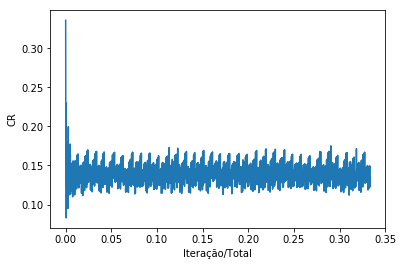

In [16]:
plt.plot(df['FRAC Its'],df['CR'])
plt.xlabel('Iteração/Total')
plt.ylabel('CR')

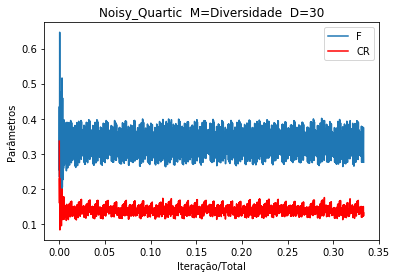

In [17]:

fig, ax = plt.subplots()
ax.plot(df['FRAC Its'],df['F'],label='F')
ax.set_xlabel('Iteração/Total')
ax.set_ylabel('Parâmetros')
ax.plot(df['FRAC Its'],df['CR'],'-r', label='CR')
nome=Fun.__name__+'  M=Diversidade'+ '  D='+str(dim)
ax.set_title(nome)
leg = ax.legend()


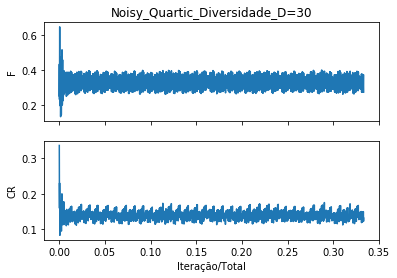

In [18]:
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(df['FRAC Its'],df['F'])
axarr[0].set_ylabel('F')
axarr[1].plot(df['FRAC Its'],df['CR'])
axarr[1].set_ylabel('CR')
axarr[1].set_xlabel('Iteração/Total')
nome=Fun.__name__+'_Diversidade_'+ 'D='+str(dim)
axarr[0].set_title(nome)


In [19]:
nome='_ANN_Div3x4_Fo-'+str(Fi)+'_CRo-'+str(CRi)+'_D-'+str(dim)+'_Interv-'+str(ITE)
print('DE_POP_VAR_F_CR','TOTAL=',TOTAL,'Iterações=',ITE*its,'Dim=', PAR,"Min/Max=",MIN[0],"/",MAX[0],'_',Fun.__name__)
print(nome, '\n')
#print('BEST: ',BEST)
#print('MÉDIA: ',MEAN)
print('MÉDIA: ',MEAN[-1])
print('MIN __:',MINFO)
print('MAX__: ',MAXFO)
print('STD __:',STD)
print("Tempo Médio= %.3f segundos ---" % (TIME))
print(RUNS,'Rodadas') 
print()
print('BEST: ',BEST)
# print('melhor=',BEST_AGENTS[BEST_INDEX])

DE_POP_VAR_F_CR TOTAL= 450000 Iterações= 3000 Dim= 30 Min/Max= -1.28 / 1.28 _ Noisy_Quartic
_ANN_Div3x4_Fo-0.5_CRo-0.5_D-30_Interv-3000 

MÉDIA:  0.131292999521
MIN __: 0.0266518390463
MAX__:  0.287268905266
STD __: 0.0490278348485
Tempo Médio= 357.505 segundos ---
50 Rodadas

BEST:  [-0.03389706 -0.10424709  0.04295405  0.02974183 -0.09874269  0.0565833
  0.12864825 -0.09591167 -0.01769603  0.07587522 -0.12930739  0.00897093
  0.03106153 -0.14645328 -0.08885     0.01571494 -0.04499056  0.00981736
 -0.02533486 -0.07094761  0.14709965 -0.04656157 -0.01786588  0.05124028
 -0.05953132  0.05732297 -0.02687843  0.04201818  0.01325926 -0.03727387
  0.02665184]
